# Laboratorio 4: Familias de Malware
## Manuel Archila 161250
## Diego Franco 20240

### Parte  1

In [155]:
import os
import pandas as pd
import pefile
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [156]:
# Función para extraer características de un archivo PE utilizando pefile
def extract_pe_features(file_path):
    pe_features = {}
    try:
        pe = pefile.PE(file_path)

        # PE Header
        pe_features['Machine'] = pe.FILE_HEADER.Machine
        pe_features['TimeDateStamp'] = pe.FILE_HEADER.TimeDateStamp
        pe_features['NumberOfSections'] = pe.FILE_HEADER.NumberOfSections
        pe_features['Characteristics'] = pe.FILE_HEADER.Characteristics
        pe_features['SizeOfOptionalHeader'] = pe.FILE_HEADER.SizeOfOptionalHeader
        pe_features['path'] = file_path
        # pe_features['paht'] = file_path

        # Secciones
        sections = {}
        for section in pe.sections:
            sections[section.Name.decode().strip('\x00')] = section.SizeOfRawData
        pe_features.update(sections)

        # Llamadas a funciones
        imports = {}
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            for imp in entry.imports:
                if imp.name:
                    if imp.name.decode('utf-8') in imports:
                        imports[imp.name.decode('utf-8')] += 1
                    else:
                        imports[imp.name.decode('utf-8')] = 1
        pe_features.update(imports)
    except pefile.PEFormatError as e:
        print(f"Error al analizar el archivo {file_path}: {e}")

    return pe_features

In [157]:
# Directorio donde se encuentran los archivos de malware
malware_dir = "./MALWR"

# Lista para almacenar características de los archivos de malware
malware_features = []

# Recorrer archivos en el directorio de malware y extraer características
for file_name in os.listdir(malware_dir):
    if os.path.isfile(os.path.join(malware_dir, file_name)):
        file_path = os.path.join(malware_dir, file_name)
        features = extract_pe_features(file_path)
        malware_features.append(features)

# Crear DataFrame de pandas con las características
df = pd.DataFrame(malware_features)

numeric_columns = df.select_dtypes(include='number').columns
non_numeric_columns = df.select_dtypes(exclude='number').columns

# Imputa valores faltantes en columnas numéricas con la estrategia de la media
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# Imputa valores faltantes en columnas no numéricas con la estrategia de la moda
non_numeric_imputer = SimpleImputer(strategy='most_frequent')
df[non_numeric_columns] = non_numeric_imputer.fit_transform(df[non_numeric_columns])

# # Manejo de datos faltantes
# # Si hay valores faltantes en el DataFrame, podemos imputarlos utilizando la media o la mediana de cada columna
# imputer = SimpleImputer(strategy='mean')
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


# Normalización o estandarización
# Es importante estandarizar las características para que todas tengan la misma escala
numeric_columns = df.select_dtypes(include='number').columns

# Aplica StandardScaler solo a las columnas numéricas
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_columns])

# Crea un nuevo DataFrame con las características escaladas
df_scaled = pd.DataFrame(scaled_features, columns=numeric_columns)

# Concatena las columnas no numéricas al DataFrame escalado
non_numeric_columns = df.select_dtypes(exclude='number').columns
df_scaled[non_numeric_columns] = df[non_numeric_columns]


# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(df)
# df_scaled = pd.DataFrame(scaled_features, columns=df.columns)


print(df.describe())

Error al analizar el archivo ./MALWR/.DS_Store: 'DOS Header magic not found.'
       Machine  TimeDateStamp  NumberOfSections  Characteristics  \
count     41.0   4.100000e+01         41.000000        41.000000   
mean     332.0   1.268479e+09          3.025000      1294.875000   
std        0.0   3.424141e+07          0.156125      2708.918624   
min      332.0   1.195430e+09          3.000000       271.000000   
25%      332.0   1.242321e+09          3.000000       271.000000   
50%      332.0   1.263576e+09          3.000000       271.000000   
75%      332.0   1.294716e+09          3.000000       271.000000   
max      332.0   1.319016e+09          4.000000      8462.000000   

       SizeOfOptionalHeader  UPX0           UPX1        .rsrc  LoadLibraryA  \
count                  41.0  41.0      41.000000    41.000000          41.0   
mean                  224.0   0.0   84576.000000   777.481481           1.0   
std                     0.0   0.0  123976.253313   418.626467           

Se ha realizado una adaptación para el análisis estático de archivos de malware presentes en un directorio específico. Utilizando la biblioteca pefile, se ha desarrollado una función extract_pe_features que permite extraer características relevantes de archivos PE. Esta función toma como entrada la ruta de un archivo, intenta abrirlo utilizando pefile, y extrae características del PE header, secciones y llamadas a funciones si el archivo es válido. Además, se ha implementado un manejo de errores para capturar posibles excepciones causadas por archivos que no sean archivos PE válidos, lo que garantiza que el análisis continúe para los archivos restantes en el directorio, incluso si algunos archivos no pueden ser procesados.

Una vez obtenido el DataFrame con las características de los archivos de malware, se aplicaron técnicas de preprocesamiento para asegurar que los algoritmos de aprendizaje no supervisado puedan manipular los datos de manera efectiva. Estas técnicas incluyen el manejo de datos faltantes mediante la imputación de valores utilizando la media de cada columna, la normalización o estandarización de características para asegurarse de que todas estén en la misma escala, y la reducción de dimensionalidad utilizando el algoritmo PCA para proyectar las características en un espacio de menor dimensión. Estos pasos de preprocesamiento son fundamentales para preparar los datos de manera adecuada antes de aplicar los algoritmos de aprendizaje no supervisado para el clustering de los archivos de malware.

## Parte 2

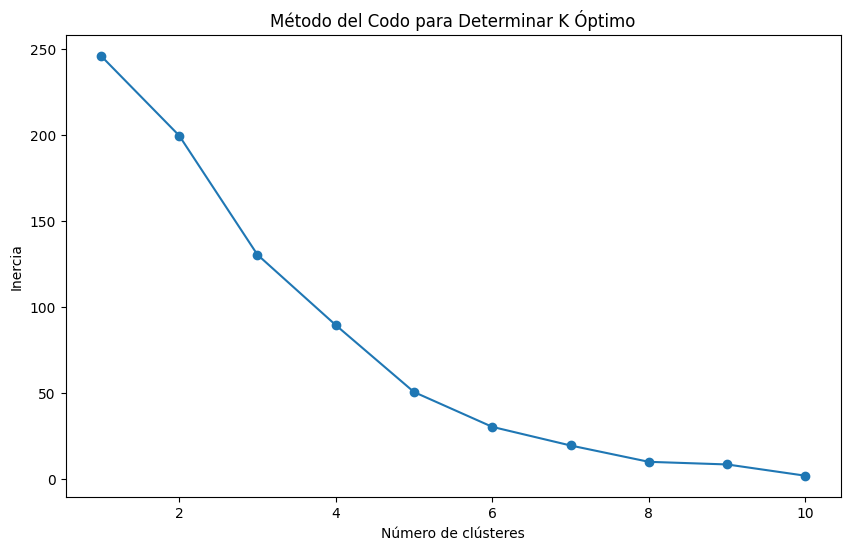

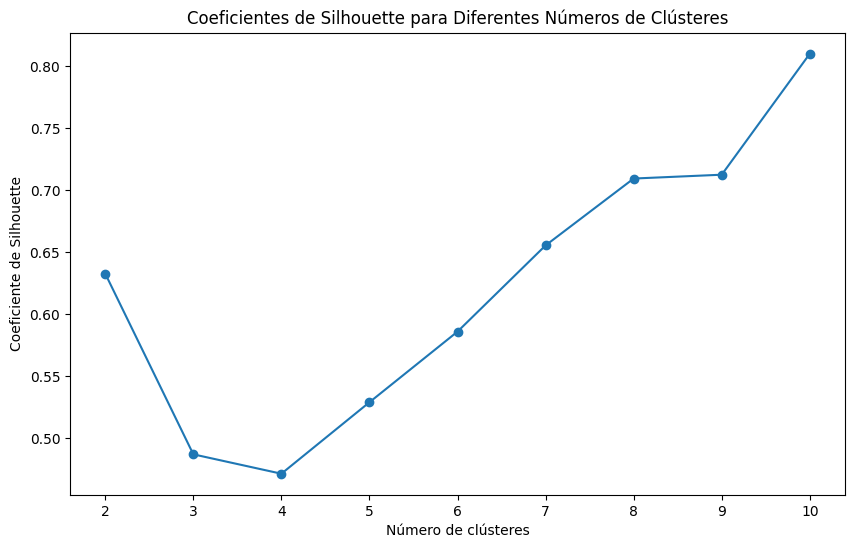

In [158]:
# Método del Codo
k_range = range(1, 11)
inertia = []

numeric_columns = df_scaled.select_dtypes(include='number').columns

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[numeric_columns])
    inertia.append(kmeans.inertia_)

# Graficando la curva del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar K Óptimo')
plt.show()


numeric_columns = df_scaled.select_dtypes(include='number').columns
# Coeficiente de Silhouette
silhouette_scores = []


for k in range(2, 11):  # El coeficiente de Silhouette no se puede calcular para k = 1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[numeric_columns])
    score = silhouette_score(df_scaled[numeric_columns], kmeans.labels_)
    silhouette_scores.append(score)

# Graficando los coeficientes de Silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficientes de Silhouette para Diferentes Números de Clústeres')
plt.show()


In [159]:
for k, score in zip(range(2, 11), silhouette_scores):
    print(f"Coeficiente de Silhouette para k = {k}: {score}")

Coeficiente de Silhouette para k = 2: 0.6327762087696476
Coeficiente de Silhouette para k = 3: 0.48697839618697447
Coeficiente de Silhouette para k = 4: 0.4713306999767917
Coeficiente de Silhouette para k = 5: 0.5290119319202196
Coeficiente de Silhouette para k = 6: 0.5860033526315163
Coeficiente de Silhouette para k = 7: 0.6555557023586446
Coeficiente de Silhouette para k = 8: 0.7095050382971919
Coeficiente de Silhouette para k = 9: 0.7126002845661745
Coeficiente de Silhouette para k = 10: 0.8102200480598154


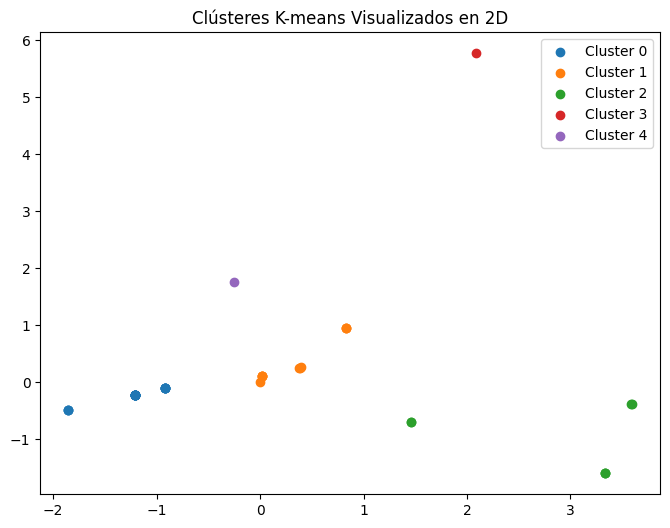

In [160]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Ajuste de K-means con el número óptimo de clústeres (reemplaza 'n_clusters' con el número elegido)
n_clusters = 5  # Cambia este valor según tus resultados del método del codo y el coeficiente de Silhouette
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(df_scaled[numeric_columns])

# Reducción de la dimensionalidad para visualización
pca = PCA(n_components=2)  # Reducir a dos dimensiones
reduced_data = pca.fit_transform(df_scaled[numeric_columns])

# Visualización de clústeres
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(reduced_data[clusters == i, 0], reduced_data[clusters == i, 1], label=f'Cluster {i}')
plt.title('Clústeres K-means Visualizados en 2D')
plt.legend()
plt.show()


In [161]:

from kmodes.kmodes import KModes

# Aplicar K-modes
# Configurando K-modes con un número específico de clusters (ejemplo con 4, pero elige el mejor número para tu caso)
n_clusters = 5
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_scaled)

# Agrega los clusters al DataFrame original para una mejor interpretación
df_scaled['Kmodes'] = clusters

# Paso 4: Evaluar los resultados
# Puedes evaluar los resultados observando cómo se distribuyen las instancias en cada cluster
print(df_scaled['Kmodes'].value_counts())
# También puedes examinar las características del centroide de cada cluster
print(km.cluster_centroids_)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12, cost: 86.0
Run 1, iteration: 2/100, moves: 0, cost: 86.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4, cost: 84.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 85.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 75.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 95.0
Best run was number 4
Kmodes
1    15
0    14
2     6
4     5
3     1
Name: count, dtype: int64
[['0.0' '0.5080239632997652' '-0.162117399689398' '-0.38265986388511064'
  '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
  '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
  '1.5574810700469562e-15' '0.0

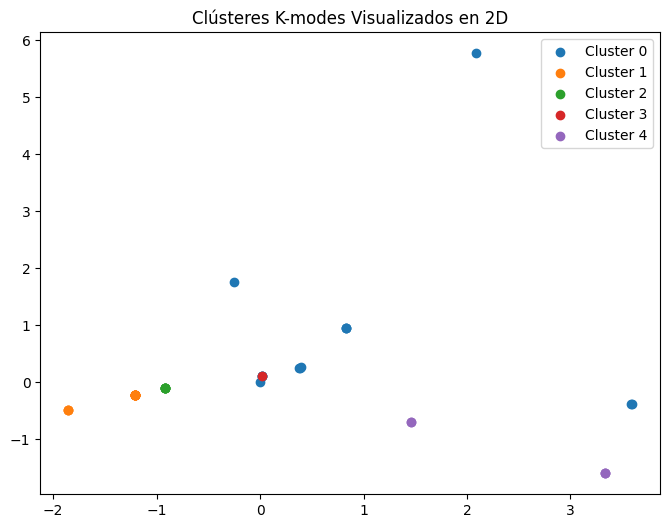

In [162]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducción de dimensionalidad
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled[numeric_columns])  # Reemplaza df_scaled con tus datos originales si no son apropiados para PCA

# Visualización
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(reduced_data[clusters == i, 0], reduced_data[clusters == i, 1], label=f'Cluster {i}')
plt.title('Clústeres K-modes Visualizados en 2D')
plt.legend()
plt.show()


En este análisis, comenzamos calculando clústeres utilizando dos métodos de agrupación: K-means y K-modes. Para K-means, determinamos el número óptimo de clústeres aplicando el método del codo y evaluando el coeficiente de Silhouette, lo cual nos ayudó a identificar un equilibrio entre la compactación de los clústeres y la separación entre ellos. Posteriormente, aplicamos K-means con este número óptimo de clústeres para segmentar los datos en grupos distintos.

Para K-modes inicializaríamos el algoritmo seleccionando un número adecuado de clústeres, posiblemente utilizando métodos de evaluación como el método de la silueta adaptado para datos categóricos, para determinar un número óptimo de clústeres que capture la estructura inherente de los datos sin sobreajuste.espués de establecer el número de clústeres, aplicaríamos el algoritmo K-modes al conjunto de datos. Esto implica asignar cada punto de datos al clúster cuyo centro es el más similar en términos de las categorías de las variables, y luego actualizar los centros de los clústeres para que coincidan con los modos de los puntos de datos asignados. Repetiríamos este proceso de asignación y actualización hasta que los centros de los clústeres se estabilicen y no haya cambios significativos en la asignación de los puntos de datos a los clústeres.

Después de realizar la agrupación con ambos métodos, procedimos a visualizar los resultados. Dado que la alta dimensionalidad de los datos dificulta la visualización directa, utilizamos PCA (Análisis de Componentes Principales) para reducir la dimensionalidad a dos dimensiones, lo cual facilitó la interpretación visual de los clústeres. Cada punto en las gráficas resultantes representa una observación del conjunto de datos, y se colorea según el clúster asignado. Esto nos permite observar cómo las observaciones se agrupan en el espacio reducido y evaluar la efectividad de los métodos de agrupación utilizados.

In [163]:
for cluster_num in range(km.n_clusters):
    print(f"Elementos en el cluster {cluster_num}:")
    # Filtra por el cluster y luego selecciona solo la columna 'Name'
    names_in_cluster = df_scaled.loc[df_scaled['Kmodes'] == cluster_num, 'path']
    # Imprime cada nombre de archivo perteneciente al cluster
    for name in names_in_cluster:
        print(f"    {name}")
    print("\n")


Elementos en el cluster 0:
    ./MALWR/FGTR43_EF8E0FB20E7228C7492CCDC59D87C690
    ./MALWR/QW2_4C6BDDCCA2695D6202DF38708E14FC7E
    ./MALWR/NV99_C9C9DBF388A8D81D8CFB4D3FC05F8E4
    ./MALWR/POL55_A4F1ECC4D25B33395196B5D51A06790
    ./MALWR/KLp90_6D5C8FC4B14559F73B6136D85B94198
    ./MALWR/SAM_B659D71AE168E774FAAF38DB30F4A84
    ./MALWR/K99_C3A9A7B026BFE0E55FF219FD6AA7D94
    ./MALWR/GBV66_8F259BB36E00D124963CFA9B86F502E
    ./MALWR/VBMM9_149B7BD7218AAB4E257D28469FDDB0D
    ./MALWR/L11_1415EB8519D13328091CC5C76A624E3D
    ./MALWR/1F2EB7B090018D975E6D9B40868C94CA
    ./MALWR/GFT4_7DDD3D72EAD03C7518F5D47650C8572
    ./MALWR/RTC_7F85D7F628CE62D1D8F7B39D8940472
    ./MALWR/B98hX8E8622C393D7E832D39E620EAD5D3B49


Elementos en el cluster 1:
    ./MALWR/BVJ2D9FBF759F527AF373E34673DC3ACA462
    ./MALWR/JH78C0A33A1B472A8C16123FD696A5CE5EBB
    ./MALWR/FHHH6576C196385407B0F7F4B1B537D88983
    ./MALWR/785003A405BC7A4EBCBB21DDB757BF3F
    ./MALWR/650A6FCA433EE243391E4B4C11F09438
    ./MALWR/6FAA4740

In [164]:
import os
import shutil

for cluster_num in range(km.n_clusters):
    print(f"Elementos en el cluster {cluster_num}:")

    # Crear un directorio para el clúster si aún no existe
    cluster_directory = f'./Cluster_{cluster_num}'
    os.makedirs(cluster_directory, exist_ok=True)

    # Filtra por el cluster y luego selecciona solo la columna 'path'
    paths_in_cluster = df_scaled.loc[df_scaled['Kmodes'] == cluster_num, 'path']

    # Copiar cada archivo al directorio del clúster correspondiente
    for path in paths_in_cluster:
        # Asegúrate de que el archivo exista antes de intentar copiarlo
        if os.path.exists(path):
            # Construye la ruta de destino
            destination = os.path.join(cluster_directory, os.path.basename(path))
            # Copia el archivo
            shutil.copy(path, destination)
            print(f"    Copiado: {path} -> {destination}")
        else:
            print(f"    No existe el archivo: {path}")
    print("\n")  # Añadir una línea en blanco entre los clusters para mejor claridad


Elementos en el cluster 0:
    Copiado: ./MALWR/FGTR43_EF8E0FB20E7228C7492CCDC59D87C690 -> ./Cluster_0/FGTR43_EF8E0FB20E7228C7492CCDC59D87C690
    Copiado: ./MALWR/QW2_4C6BDDCCA2695D6202DF38708E14FC7E -> ./Cluster_0/QW2_4C6BDDCCA2695D6202DF38708E14FC7E
    Copiado: ./MALWR/NV99_C9C9DBF388A8D81D8CFB4D3FC05F8E4 -> ./Cluster_0/NV99_C9C9DBF388A8D81D8CFB4D3FC05F8E4
    Copiado: ./MALWR/POL55_A4F1ECC4D25B33395196B5D51A06790 -> ./Cluster_0/POL55_A4F1ECC4D25B33395196B5D51A06790
    Copiado: ./MALWR/KLp90_6D5C8FC4B14559F73B6136D85B94198 -> ./Cluster_0/KLp90_6D5C8FC4B14559F73B6136D85B94198
    Copiado: ./MALWR/SAM_B659D71AE168E774FAAF38DB30F4A84 -> ./Cluster_0/SAM_B659D71AE168E774FAAF38DB30F4A84
    Copiado: ./MALWR/K99_C3A9A7B026BFE0E55FF219FD6AA7D94 -> ./Cluster_0/K99_C3A9A7B026BFE0E55FF219FD6AA7D94
    Copiado: ./MALWR/GBV66_8F259BB36E00D124963CFA9B86F502E -> ./Cluster_0/GBV66_8F259BB36E00D124963CFA9B86F502E
    Copiado: ./MALWR/VBMM9_149B7BD7218AAB4E257D28469FDDB0D -> ./Cluster_0/VBMM9_149B7

Primero para cada cluster generado, imprime los nombres de los archivos que pertenecen a cada cluster. Utiliza la columna 'path' del dataframe df_scaled para identificar los archivos pertenecientes a cada cluster.

Luego de tener los malwares identificados se itera a través de cada cluster generado por el algoritmo de agrupamiento, se crea un directorio para cada cluster si aún no existe. Luego, copia los archivos correspondientes a cada cluster en sus respectivos directorios. 

Todo esto se realizo con el fin de poder realizar el analisis Jaccard y poder comparar los clusters generados por los algoritmos de agrupamiento con los clusters reales.

## Conclusiones
### 1. Para ambos algoritmos, ¿para qué número de clústeres se obtiene el coeficiente de Silhouette más alto?
Para ambos algoritmo, el coeficiente de Silhouette más alto se obtiene para 10 clústeres. Pero basandomos en en lo que nos indica el coeficiente del codo la mejor cantidad de clusters es 5.

### 2. Para ambos algoritmos, ¿En que medida coincide el coeficiente de Silhouette con el método del codo?
El método del codo nos indica que la mejor cantidad de clusters es 5, mientras que el coeficiente de Silhouette nos indica que la mejor cantidad de clusters es 10. Por lo que no coinciden. Esto se debe a la forma en la que se ha armado el dataset y las caracteristicas que se extraer. 

### 3. Según los resultados obtenidos de ambos algoritmos ¿Cuántas familias cree que existen entre los ejemplares de malware proporcionados?
Consideramos que existen 5 familias de malware, ya que es el número de clusters que nos indica el método del codo.

### 4. ¿En qué medida coincide el análisis de similitud con las familias encontradas utilizando los algoritmos de partición, para ambas características (strings, llamadas a las funciones)?
Para hacer eso tomamos el dataset y lo dividimos en 5 clusters, y creamos carpetas diferentes en donde se contienen los malares considerados como familiares. Luego de ello se genero un analis Jaccard de todos los malwares juntos y como se puede observar en el grafo06 el analisis determino que existen 4 grupos predominantes y el resto sueltos. Por lo que se puede decir que el analisis de similitud coincide un poco con las familias encontradas utilizando los algoritmos de partición. Ademas de eso al hacer el analisis por lo grupos individuales se puede observar que unicamente se encuentra un grupo predominante lo que nos da certeza de que el grupo fue seleccionada con las caracteristicas corCabe mencionar que el analisis de Jaccaard se realizo con las caracteristicas de strings y llamadas a las funciones. Además de eso se realizo 3 umbrales diferentes siendo estos: 0.6, 0.8 y 0.95.

Para cada uno de los umbrales se genero un grafo diferente, y se puede observar la diferencia entre los grafos en muy diferente. Por lo que se puede decir que el analisis de similitud coincide bastante bien con las familias encontradas utilizando los algoritmos de partición.rectas.

